# Set up

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt

# Run MVP script

In [4]:
%run mvp.py

1928 1932
1933 1937
1938 1942
1943 1947
1948 1952
1953 1957
1958 1962
1963 1967
1968 1972
1973 1977
1978 1982
1983 1987
1988 1992
1993 1997
1998 2002
2003 2007
2008 2012
2013 2017


# Calculate matrix with rolling 5-year returns

For each year range,
    - calculate the 5-year returns
    - write the returns for the 5 years into a new row
   
Form quantiles for each column

In [5]:
return_mat = np.zeros((params["year_end"] - params["year_start"] + 1 - params["year_step_size"] + 1, 6))

In [6]:
for first_year in range(params["year_start"], params["year_end"] + 1 - params["year_step_size"] + 1):
    print(first_year)
    
    end = first_year + params["year_step_size"] - 1
    df_returns = df_all_returns.loc[first_year:end, :]
    df_cum_returns = (pd.DataFrame(data=get_cum_net_returns(df_returns.to_numpy()),
                                   index=range(first_year, end + 1))
                     )
    df_cum_returns.columns = df_returns.columns
    df_cum_returns_normalised = make_plot_df(df_cum_returns)
    
    row_idx = first_year - params["year_start"]
    print(row_idx)
    return_mat[row_idx,:] = df_cum_returns_normalised["portfolio"].to_numpy().round(2)

1928
0
1929
1
1930
2
1931
3
1932
4
1933
5
1934
6
1935
7
1936
8
1937
9
1938
10
1939
11
1940
12
1941
13
1942
14
1943
15
1944
16
1945
17
1946
18
1947
19
1948
20
1949
21
1950
22
1951
23
1952
24
1953
25
1954
26
1955
27
1956
28
1957
29
1958
30
1959
31
1960
32
1961
33
1962
34
1963
35
1964
36
1965
37
1966
38
1967
39
1968
40
1969
41
1970
42
1971
43
1972
44
1973
45
1974
46
1975
47
1976
48
1977
49
1978
50
1979
51
1980
52
1981
53
1982
54
1983
55
1984
56
1985
57
1986
58
1987
59
1988
60
1989
61
1990
62
1991
63
1992
64
1993
65
1994
66
1995
67
1996
68
1997
69
1998
70
1999
71
2000
72
2001
73
2002
74
2003
75
2004
76
2005
77
2006
78
2007
79
2008
80
2009
81
2010
82
2011
83
2012
84
2013
85
2014
86


In [7]:
return_mat.shape

(87, 6)

# Check that all entries have been filled

In [8]:
np.where(return_mat == 0)

(array([], dtype=int32), array([], dtype=int32))

# Sort matrix with returns

In [9]:
for column in range(1, return_mat.shape[1]):
    return_mat[:, column].sort()

In [10]:
return_mat[0:10,:]

array([[100.  ,  88.34,  85.8 ,  86.5 ,  88.66,  98.31],
       [100.  ,  91.93,  90.55,  87.95,  97.  ,  99.43],
       [100.  ,  95.82,  95.86,  97.72,  99.97, 100.78],
       [100.  ,  96.46,  96.4 , 101.63, 102.61, 103.73],
       [100.  ,  97.08,  97.92, 102.56, 103.6 , 111.48],
       [100.  ,  97.13, 100.61, 102.92, 106.79, 113.39],
       [100.  ,  97.31, 101.45, 103.23, 106.94, 113.42],
       [100.  ,  99.55, 101.59, 104.14, 109.15, 113.99],
       [100.  ,  99.94, 101.62, 108.5 , 109.36, 116.07],
       [100.  , 100.04, 101.98, 108.96, 111.62, 120.72]])

# Generate matrix with CI quantiles to plot

In [11]:
quantile_mat = np.zeros([5, 6])

for col in range(quantile_mat.shape[1]):
    quantile_mat[0,col] = np.quantile(return_mat[:,col], 0.025)
    quantile_mat[1,col] = np.quantile(return_mat[:,col], 0.16)
    quantile_mat[2,col] = np.quantile(return_mat[:,col], 0.5)
    quantile_mat[3,col] = np.quantile(return_mat[:,col], 0.84)
    quantile_mat[4,col] = np.quantile(return_mat[:,col], 0.975)

quantile_mat

array([[100.    ,  95.916 ,  95.941 ,  98.3065, 100.366 , 101.2225],
       [100.    , 100.8008, 103.2208, 110.6504, 115.9124, 121.4356],
       [100.    , 106.5   , 112.25  , 118.01  , 124.8   , 130.23  ],
       [100.    , 111.2356, 121.4408, 131.0852, 145.6808, 160.3248],
       [100.    , 121.868 , 135.291 , 150.1765, 172.6115, 188.1235]])

In [12]:
df_quantile_mat = pd.DataFrame(data=quantile_mat, columns=["y0", "y1", "y2", "y3", "y4", "y5"]) 

# Plot CI graph

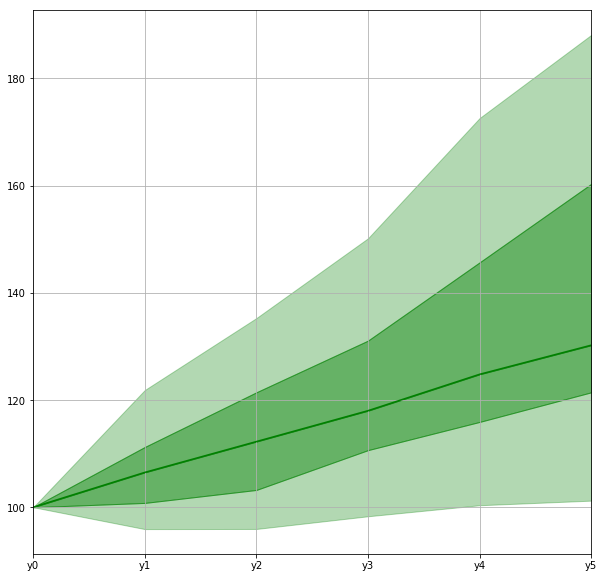

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
# for i in range(5):
#     df_quantile_mat.iloc[i].plot(ax=ax)
df_quantile_mat.iloc[2].plot(ax=ax, color="green")
ax.fill_between(df_quantile_mat.columns, df_quantile_mat.iloc[0], df_quantile_mat.iloc[1], alpha=0.3, color="green")
ax.fill_between(df_quantile_mat.columns, df_quantile_mat.iloc[1], df_quantile_mat.iloc[2], alpha=0.6, color="green")
ax.fill_between(df_quantile_mat.columns, df_quantile_mat.iloc[2], df_quantile_mat.iloc[3], alpha=0.6, color="green")
ax.fill_between(df_quantile_mat.columns, df_quantile_mat.iloc[3], df_quantile_mat.iloc[4], alpha=0.3, color="green")
plt.grid(True)